### Finetuning : **Grad-ECLIP: Gradient-based Visual and Textual Explanations for CLIP**

Dans le cadre de cette partie, nous implémentons la méthode de finetuning utilisan Grad-ECLIP, présentée dans l'article “Grad-ECLIP: Gradient-based Visual and Textual Explanations for CLIP”. Cet article met en lumière une limitation majeure de CLIP : sa difficulté à comprendre les détails fins (fine-grained) d’une image, notamment en ce qui concerne la reconnaissance des régions spécifiques lors de l’utilisation de ses caractéristiques denses. Cette faiblesse s'explique par le fait que CLIP a été pré-entraîné principalement pour aligner l’image globale (via le jeton [CLS]) avec une description textuelle, sans nécessairement apprendre une correspondance fine entre régions visuelles et attributs textuels.

Pour pallier cette limitation, les auteurs proposent Grad-ECLIP, un mécanisme qui génère des cartes explicatives textuellement guidées à partir de l’encodeur visuel de CLIP. Ces cartes mettent en évidence les régions pertinentes de l’image pour une paire image-texte donnée. L’optimisation de CLIP par ce biais permet de renforcer l’alignement local entre les régions visuelles et les éléments textuels, tout en conservant les capacités globales du modèle. Ainsi, le modèle optimisé améliore sensiblement la reconnaissance régionale pour des tâches de prédiction dense, tout en maintenant ses performances sur les tâches classiques de correspondance image-texte.


##### **Objectifs de cette partie**

- **Implémenter** l’approche du fine-tuning pour Grad-eclip 
- **Etudier** le mécanisme pour le fine-tuning en fonction de la loss
- **Comprendre** comment Grad-Eclip parvient à améliorer l'alignement image-texte durant le fine-tuning pour la détection open-vocabulary ou la classification régionale.
- **Reproduire les résultats de l'article**


## Etapes principales du fine-tuning

1. **Préparation des données et définition du modèle**

2. **Extraction des objets ou entités nommées à partir des légendes**

3. **Préparation du fine-tuning CLIP : prétraitement et heatmap Grad-ECLIP**

4. **Visualisation & calcul de la Local Loss (Grad-ECLIP)**

5. **Préparation du DataLoader, Optimiseur et Environnement GPU/CPU**

6. **Évaluation sur des tâches de reconnaissance régionale**







#### Explication de l'architecture pour le fine-tuning

La méthode de fine-tuning suggérée **Grad-ECLIP** ajuste CLIP en détail. Elle exploite les correspondances locales entre les régions d’image et ses éléments textuels. Les objets comme le chien, la voiture noire sont extraits à l’aide de la bibliothèque NLTK. Les cartes de chaleur sont générées par Grad-ECLIP. Elles appliquent un poids sur les descripteurs régionaux visuels à partir des caractéristiques denses de l’image. Puis, elles sont agrégées. L’apprentissage  de cela s’effectue donc à travers deux fonctions de perte. La perte globale est similaire à celle utilisée dans le pré-entraînement de CLIP. La perte locale apparie les régions visuelles avec les descripteurs textuels locaux associés aux objets identifiés.

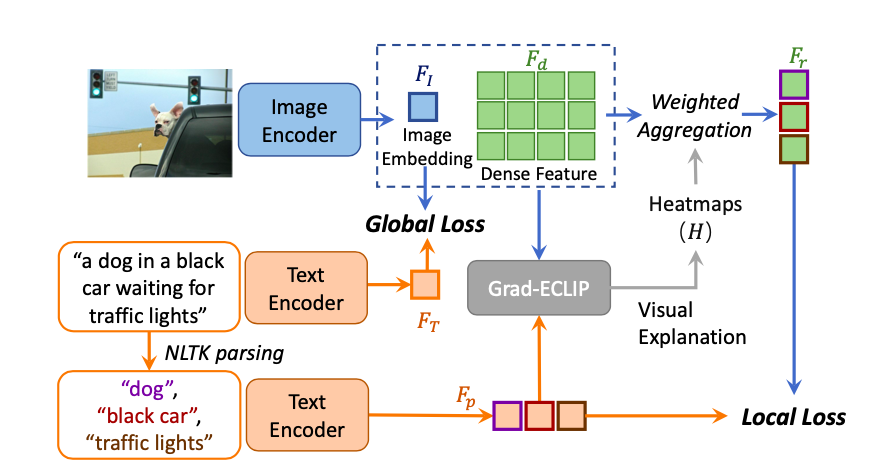

## Installation des bibliothèques essentielles pour le projet :

        huggingface_hub : pour télécharger et publier des modèles

        datasets : pour charger CC3M ou d'autres jeux de données

        timm : accès à des modèles vision modernes

        ftfy : corrige les légendes mal encodées

In [6]:
# Install necessary libraries
!pip install -U huggingface_hub datasets timm ftfy
!pip install nltk transformers torchvision
!pip install nltk
!pip install torch

  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached hf_xet-1.1.3-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (879 bytes)
  Using cached numpy-2.3.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  

*  Installation de :

        nltk pour le traitement linguistique (POS tagging, extraction de mots)

        transformers pour utiliser CLIP via HuggingFace

        torchvision pour les transformations d’images (resize, normalize...)

* Téléchargement des ressources linguistiques nécessaires :
punkt, tagger, etc. servent à découper les légendes et à identifier les objets (noms, entités nommées…)

In [4]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download("words")

[nltk_data] Downloading package punkt_tab to /home/paul/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/paul/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/paul/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /home/paul/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /home/paul/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [15]:
!pip install torch
import torch

  Using cached torch-2.7.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
Using cached torch-2.7.1-cp312-cp312-manylinux_2_28_x86_64.whl (821.0 MB)
Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl (571.0 MB)
Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (200.2 MB)
Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (158.2 MB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 3/5 [nvidia-cusolver-cu12]ERROR: Could not install p

ModuleNotFoundError: No module named 'torch'

# 1. Chargement des modèles CLIP préentraînés

Nous avons eu recours au vision transformer VIT-B/16 et VIT-B/32. Ceux-ci apprennent globalement les relations entre le texte et l'image. Leur coût de calcul est moindre par rapport à d'autres modèles comme VIT-L/14.

**Explication :**

        Cette cellule charge le modèle CLIP ViT-B/16 préentraîné via la bibliothèque transformers de Hugging Face.

        CLIPModel permet d’obtenir les embeddings d’image et de texte.

        CLIPProcessor est utilisé pour normaliser les images et tokeniser les textes selon les standards de CLIP.

        Le modèle est déplacé sur GPU (CUDA) si disponible, sinon sur CPU.

**Ce modèle sera ensuite fine-tuné sur le dataset pour mieux aligner les régions d’image avec les descriptions textuelles spécifiques (méthode Grad-ECLIP).**

In [11]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load pre-trained CLIP model
model_clip_vit_base_patch16 = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor_clip_vit_base_patch16 = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip_vit_base_patch16 = model_clip_vit_base_patch16.to(device)

ModuleNotFoundError: No module named 'torch'

In [6]:
model_clip_vit_large_patch14 = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor_clip_vit_large_patch14 = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model_clip_vit_large_patch14 = model_clip_vit_large_patch14.to(device)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [7]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
import gc
from tqdm import tqdm
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import roi_pool
from transformers import CLIPProcessor, CLIPModel
from torchvision.transforms.functional import to_pil_image

In [8]:
# === CHARGEMENT DES LIBRAIRIES ===
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import requests
from io import BytesIO
from torch.optim import AdamW
from tqdm import tqdm
import gc
import os
import hashlib

 # 2. Préparation des données  et définition du modèle
 **Détails des fonctionnalités**

**classe TSVCC3MDataset**

        Manipule un fichier .tsv contenant des paires (caption, url) extraites du dataset CC3M (ou autre source équivalente). 

**__ init__**

        Charge un nombre maximal de lignes (max_samples) depuis un fichier .tsv.

        Pour chaque ligne contenant une URL, extrait la légende (caption) et l’URL (url).

        Les images seront ensuite téléchargées ou chargées depuis un cache local (cache_dir).

**_url_to_filename**

        Transforme une URL en nom de fichier unique via un hash (md5).

        Utilisé pour nommer les fichiers cache localement (évite les doublons).

**_load_or_download_image**

        Si l’image existe déjà dans le cache, elle est chargée directement.

        Sinon, elle est téléchargée depuis l’URL, convertie en RGB et sauvegardée.

        Vérifie que l’image est valide (taille minimale) ; sinon elle est supprimée ou remplacée par une image noire (224×224), ce qui évite de casser l’entraînement.

**__ len__**

     Renvoie le nombre total de paires (image, légende) valides.

**__ getitem__**

        Retourne un dictionnaire { "image": image, "caption": caption } pour un index donné.

        Cette sortie est compatible avec les modèles transformers comme CLIP.

**Remarque utile :**
Ce dataset est robuste, car il :

* gère les erreurs réseau ou les corruptions,

* met en cache les images pour éviter de retélécharger,

* s’adapte à n’importe quel .tsv structuré.

In [9]:
#Définition de la classe TSVCC3MDataset (Dataset personnalisé)
class TSVCC3MDataset(Dataset):
    """ Description générale :
Cette classe définit un torch.utils.data.Dataset pour manipuler un fichier .tsv contenant des paires (caption, url) extraites du dataset CC3M (ou autre source équivalente).
    """
    def __init__(self, tsv_path, cache_dir="cache_images", max_samples=10000):
        self.entries = []
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

        # Read and parse lines
        with open(tsv_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if "http" not in line:
                    continue
                parts = line.split("http", 1)
                caption = parts[0].strip()
                url = "http" + parts[1].strip()
                self.entries.append((caption, url))
                if len(self.entries) >= max_samples:
                    break

    def _url_to_filename(self, url):
        return hashlib.md5(url.encode()).hexdigest() + ".jpg"

    def _load_or_download_image(self, url):
        filename = self._url_to_filename(url)
        filepath = os.path.join(self.cache_dir, filename)

        if os.path.exists(filepath):
            try:
                image = Image.open(filepath).convert("RGB")
                if image.size[0] < 10 or image.size[1] < 10:
                    raise ValueError("Image too small")
                return image
            except:
                os.remove(filepath)  # Supprimer le fichier corrompu

        try:
            response = requests.get(url, timeout=5)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            if image.size[0] < 10 or image.size[1] < 10:
                raise ValueError("Image too small")
            image.save(filepath)
            return image
        except:
            # Remplacer l’image par une image noire de secours (3 canaux, RGB)
            return Image.new("RGB", (224, 224), color=(0, 0, 0))


    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        caption, url = self.entries[idx]
        image = self._load_or_download_image(url)
        return {"image": image, "caption": caption}

**Chargement du dataset à partir des fichiers .tsv**


In [10]:
# === CHARGEMENT DU DATASET DEPUIS LE FICHIER TSV ===
tsv_train_path = "/kaggle/input/cc3m-tsv/Train_GCC-training.tsv"
tsv_validation_path = "/kaggle/input/cc3m-tsv/Validation_GCC-1.1.0-Validation.tsv"
train_dataset = TSVCC3MDataset(tsv_train_path, max_samples=1000)  # tu peux ajuster ce nombre
val_dataset = TSVCC3MDataset(tsv_validation_path, max_samples=300)

**Explication :**

        Chargement de deux sous-ensembles du dataset Conceptual Captions (CC3M) : un pour l'entraînement, l’autre pour la validation.

        Chaque fichier .tsv contient des paires texte + lien d’image (caption + URL).

        Le max_samples permet de limiter le nombre d'exemples pour s'adapter à la mémoire disponible (Kaggle ou Colab).

* Le dataset utilisé est la classe personnalisée TSVCC3MDataset (définie précédemment), qui :

        télécharge les images au besoin,

        les met en cache,

        remplace les erreurs par des images noires.

**Visualisation d’un exemple**

In [11]:
sample = train_dataset[0]

In [12]:
sample

{'image': <PIL.Image.Image image mode=RGB size=800x534>,
 'caption': 'a very typical bus station'}

In [13]:
print("Caption:", sample["caption"])

Caption: a very typical bus station


* Affiche une instance du dataset d’entraînement.
* On y voit un dictionnaire contenant une image (PIL.Image) et sa légende associée (caption).

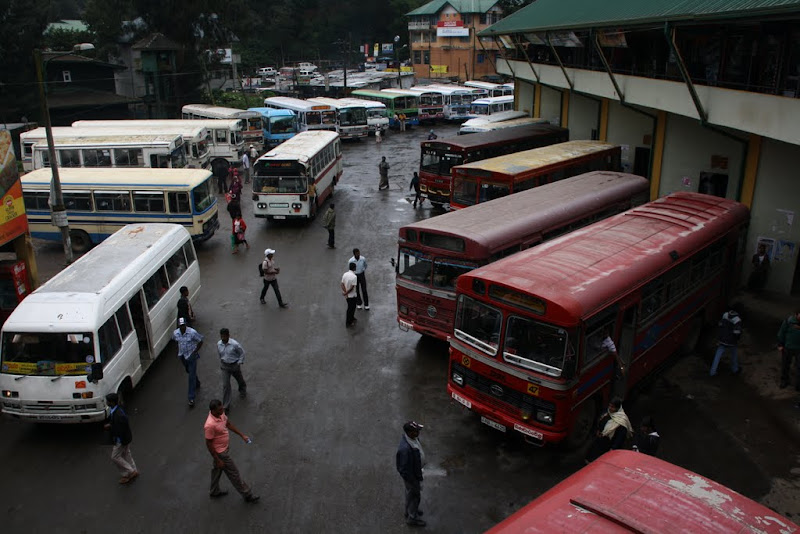

In [14]:
display(sample["image"])

**Comptage du nombre total de lignes dans les fichiers .tsv**

In [15]:
def count_lines_tsv(tsv_path):
    with open(tsv_path, "r", encoding="utf-8") as f:
        return sum(1 for _ in f)

train_total_size = count_lines_tsv(tsv_train_path)
val_total_size = count_lines_tsv(tsv_validation_path)

print(f"Taille réelle du dataset d'entraînement : {train_total_size} échantillons")
print(f"Taille réelle du dataset de validation : {val_total_size} échantillons")

Taille réelle du dataset d'entraînement : 3318333 échantillons
Taille réelle du dataset de validation : 15840 échantillons


In [16]:
from nltk import word_tokenize, pos_tag
import nltk
import os
import re

# 3. Extraction des objets ou entités nommées à partir des légendes

In [17]:
def extract_named_entities(captions):
    all_entities = []
    for text in captions:
        words = word_tokenize(text)
        tagged = pos_tag(words)
        concepts = []

        for i in range(len(tagged) - 1):
            word, tag = tagged[i]
            next_word, next_tag = tagged[i + 1]
            if tag.startswith("JJ") and next_tag.startswith("NN"):
                concepts.append(f"{word} {next_word}")
            elif tag.startswith("NN"):
                concepts.append(word)

        all_entities.append(list(set(concepts)))
    return all_entities



**Explication :**

        Cette fonction extrait des concepts visuels importants (objets ou entités) à partir de phrases (légendes).

**Elle utilise nltk pour :**

    - découper le texte en mots : word_tokenize

    - identifier leur catégorie grammaticale : pos_tag

    Elle extrait :

    - les noms (NN, NNS, etc.) → ex : "dog", "car"

    - les paires adjectif + nom (JJ + NN) → ex : "black car", "white dog"

* Cette étape est cruciale dans Grad-ECLIP pour générer une Local Loss basée sur des objets précis.

**Pourquoi c’est utile ?**

* Ces mots ou expressions seront encodés individuellement avec CLIP.

* Le modèle apprendra à aligner chaque mot avec une région spécifique de l’image, renforçant la correspondance fine image-texte.

In [18]:
text = "A dog in a black car is waiting for the traffic lights."
entities = extract_named_entities([text])
print(entities)

[['traffic', 'dog', 'black car', 'car', 'lights']]


# 4. Préparation du fine-tuning CLIP : prétraitement et heatmap Grad-ECLIP

In [19]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
import gc

# Preprocessing function
# --- Preprocessing ---
def preprocess(batch,processor):
    # batch["caption"] est une liste de chaînes de caractères
    # Pas besoin de tokenizer manuellement, CLIPProcessor s'en charge
    inputs = processor(text=batch["caption"], images=batch["image"], return_tensors="pt", padding=True, truncation=True)
    return {k: v.to(device) for k, v in inputs.items()}

def preprocess(batch,processor):
    valid_images = []
    valid_captions = []
    for img, caption in zip(batch["image"], batch["caption"]):
        try:
            img = img.convert("RGB")  # force au cas où
            valid_images.append(img)
            valid_captions.append(caption)
        except:
            continue  # ignorer les images corrompues

    inputs = processor(text=valid_captions, images=valid_images, return_tensors="pt", padding=True, truncation=True)
    return {k: v.to(device) for k, v in inputs.items()}
# --- Heatmap generation ---
def generate_heatmap(image_tensor, model, text_input_ids, attention_mask):
    model.eval()
    image_tensor.requires_grad = True

    outputs = model.vision_model(pixel_values=image_tensor, output_hidden_states=True, return_dict=True)
    patch_tokens = outputs.hidden_states[-1][:,1:,:]  # remove CLS token
    B, N, C = patch_tokens.shape
    H = W = int(N ** 0.5)
    patch_map = patch_tokens.reshape(B, H, W, C).permute(0, 3, 1, 2)  # [B, C, H, W]

    # Obtenir les features textuels
    text_feat = model.text_model(input_ids=text_input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
    text_feat = model.text_projection(text_feat)  # Projette déjà en 512 normalement
    text_feat = text_feat / text_feat.norm(p=2, dim=-1, keepdim=True)

    if patch_map.shape[1] != text_feat.shape[1]:
        # Projeter text_feat à la dimension de patch_map (ex: de 768 → 512)
        projection_matrix = torch.eye(patch_map.shape[1], text_feat.shape[1]).to(text_feat.device)  # [512, 768]
        text_feat = text_feat @ projection_matrix.T  # [1, 768] × [768, 512] = [1, 512]


    # Similarité patchs vs texte
    patch_map = patch_map / patch_map.norm(p=2, dim=1, keepdim=True)
    sim_map = torch.einsum('bchw,bc->bhw', patch_map, text_feat)

    # Backprop pour gradients
    sim_map_mean = sim_map.mean()
    sim_map_mean.backward(retain_graph=True)

    gradients = image_tensor.grad
    grad_map = gradients.abs().mean(dim=1).squeeze(0).cpu().detach().numpy()
    heatmap = (grad_map - grad_map.min()) / (grad_map.max() - grad_map.min() + 1e-8)
    return heatmap


**Prétraitement du batch (fonction preprocess)**

**Explication :**

* Cette fonction prépare les paires image + légende pour le modèle CLIP.

* Elle vérifie que les images sont bien en format RGB (évite les bugs sur des images mal codées).

* Elle utilise le CLIPProcessor pour :

* appliquer les __transformations visuelles__ (resize, normalisation…)

* __tokeniser__ les textes (pas besoin de le faire manuellement).

* Elle renvoie un dictionnaire inputs contenant les tenseurs prêts à être passés dans le modèle (déjà sur le bon device).

        Cette fonction est utilisée avant chaque passage dans le modèle pour l’entraînement ou l’évaluation.

**Génération de heatmap Grad-ECLIP**

**Explication étape par étape :**

1. **Activation des gradients sur l’image**

* __image_tensor.requires_grad = True__ → nécessaire pour obtenir un gradient par rapport à l’image.

2. **Extraction des features visuels**

* On extrait les __features des patches__ d’image (dernière couche de vision transformer).

* Les patches sont remis en forme 2D : __[B, C, H, W]__.

3. **Encodage du texte**

* Les __text_input_ids__ sont passés dans le modèle texte, puis projetés dans l’espace visuel via __text_projection__.

* La feature textuelle est normalisée (cosine similarity).

4. **Alignement dimensionnel (si nécessaire)**

* Si la dimension des features visuels ne correspond pas à celle du texte, on projette l’un dans l’autre via une __matrice identité__(fallback).

5. **Carte de similarité**

* Calcul de la __similarité cosinus entre chaque patch et le texte__ via un einsum.

6. **Backpropagation du gradient**

* On effectue un backward sur la __moyenne de la carte de similarité__ pour obtenir un gradient image.

7. **Construction de la heatmap**

* Le gradient est agrégé en moyenne sur les canaux (RGB).

* La carte est normalisée entre 0 et 1 pour être affichable.

    Le résultat est une __carte de chaleur 2D__ (heatmap) qui indique les zones visuellement les plus pertinentes pour le mot ou la phrase donnée.


Cette heatmap est utilisée pour :

        pondérer spatialement les features d’image (Fᵣ),

        guider la local loss dans Grad-ECLIP,

        et interpréter visuellement l’attention du modèle.

# 5. Visualisation & calcul de la Local Loss (Grad-ECLIP)

In [20]:
# --- Show heatmap ---
def show_heatmap_on_image(image, heatmap):
    import matplotlib.cm as cm
    image = np.array(image)
    heatmap_resized = np.array(
        plt.imshow(heatmap, cmap='jet', alpha=0.5, interpolation='bilinear').get_array()
    )
    heatmap_color = cm.jet(heatmap_resized)[:,:,:3] * 255
    heatmap_color = heatmap_color.astype(np.uint8)
    overlay = (0.6 * image + 0.4 * heatmap_color).astype(np.uint8)
    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()
def heatmap_to_boxes(heatmap, threshold=0.3):
    coords = np.argwhere(heatmap > threshold)
    if coords.shape[0] == 0:
        return torch.empty((0,4))  # No box
    y1, x1 = coords.min(axis=0)
    y2, x2 = coords.max(axis=0)
    h, w = heatmap.shape
    box = torch.tensor([[x1 / w, y1 / h, x2 / w, y2 / h]], dtype=torch.float32)  # normalized box
    return box
# --- Local loss ---
def compute_local_loss(image_features, text_features, boxes, aggregation='mean'):
    B, C, H, W = image_features.shape
    loss_local = 0
    count = 0
    for i in range(B):
        box = boxes[i].to(device)
        if box.shape[0] == 0:
            continue
        pixel_boxes = box.clone()
        pixel_boxes[:, [0, 2]] *= W
        pixel_boxes[:, [1, 3]] *= H
        roi_feats = roi_pool(image_features[i].unsqueeze(0), [pixel_boxes], output_size=(1,1))
        roi_feats = roi_feats.squeeze(-1).squeeze(-1)
        text_feat = text_features[i].unsqueeze(0)
        if roi_feats.shape[1] != text_feat.shape[1]:
            projection_matrix = torch.eye(roi_feats.shape[1], text_feat.shape[1]).to(text_feat.device)  # [768, 512]
            text_feat = text_feat @ projection_matrix.T  # [1, 512] × [512, 768] = [1, 768]

        sims = F.cosine_similarity(roi_feats, text_feat, dim=-1)
        if aggregation == 'mean':
            region_score = sims.mean()
        elif aggregation == 'max':
            region_score = sims.max()
        else:
            raise ValueError("aggregation must be 'mean' or 'max'")
        loss_local -= region_score
        count += 1
    return loss_local / max(count, 1)

**Visualisation de la heatmap superposée à l’image**

**Explication :  show_heatmap_on_image()**

* Affiche une __image + sa heatmap__ générée par __generate_heatmap()__.

* La heatmap est colorée avec le colormap *'jet'* (couleur chaude = zone importante).

* On la superpose à l’image originale avec une transparence (alpha).

__Résultat__ : une __visualisation interprétable__ des zones activées par un mot/texte donné.

        Très utile pour valider visuellement que le modèle associe bien les mots aux bonnes régions.

**Conversion de la heatmap en boîte englobante**

**Explication : heatmap_to_boxes()**

* À partir d’une heatmap (valeurs entre 0 et 1), on sélectionne les __pixels les plus actifs (> 0.3)__.

* On calcule les coordonnées de la __bounding box minimale__ qui entoure tous ces points.

* La box est renvoyée en coordonnées __normalisées__ ([x1, y1, x2, y2]) ∈ [0, 1].

        Cela sert à isoler la région visuelle associée à un mot pour calculer la perte locale.


**Calcul de la Local Loss (Grad-ECLIP)**

**Explication :compute_local_loss()**

**_Prend**_ :

* des __features d’image__ (patchs visuels),

* des __features de mots__ (phrases ou concepts extraits),

* et les __boîtes__ générées par heatmap_to_boxes().

**_Pour chaque image**_ :

On extrait les features __dans la région de la boîte__ grâce à roi_pool.

On compare ces features à la représentation du mot avec __cosine similarity__.

On agrège (moyenne ou max) pour produire une __score local__.

        La Local Loss est alors -similarité, c’est-à-dire : plus la région est proche du mot, plus la perte est faible.

**Ce mécanisme est au cœur de Grad-ECLIP : il force le modèle à localiser correctement les mots dans l’espace visuel.**

# 6. Préparation du DataLoader, Optimiseur et Environnement GPU/CPU

In [21]:
def collate_fn(batch):
    imgs = [b["image"] for b in batch]
    caps = [b["caption"] for b in batch]
    return {"image": imgs, "caption": caps}

#Définition du DataLoader, optimiseur et nombre d’epoch
"""batch_size=4 : plus petit batch adapté aux capacités GPU

AdamW : optimiseur adapté pour fine-tuning de transformers (avec régularisation de poids)

lr=5e-6 : très petit learning rate → standard pour fine-tuning

num_epochs=5 : nombre d’époques à entraîner (modifiable selon durée/ressources)
"""
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
optimizer = AdamW(model_clip_vit_base_patch16.parameters(), lr=5e-6)
num_epochs = 5

**Explication :Fonction collate_fn personnalisée**

Cette fonction regroupe les exemples individuels d’un batch.

* Au lieu de les empiler automatiquement comme PyTorch le ferait, elle :

        conserve les images sous forme de liste (PIL.Image)

        conserve les captions telles quelles

* Cette structure est idéale pour les passer ensuite au CLIPProcessor qui accepte des listes d’images et de textes.


**Ce collate_fn est spécifié dans le DataLoader pour gérer le batching personnalisé.**



In [22]:
#Sélection du device (GPU ou CPU)
"""  
Détection automatique de l’environnement :

si CUDA est dispo (GPU), le modèle est déplacé dessus

sinon, il s’exécutera sur CPU (plus lent)"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clip_vit_base_patch16 = model_clip_vit_base_patch16.to(device)

**Boucle d'entraînement CLIP avec Grad-ECLIP (Global + Local Loss)**


Concernant la valeur du **taux d'apprentissage**, nous avons décidé qu'elle soit suffisamment petite pour garantir une bonne convergence. Elle permet de préserver les connaissances acquises lors du pré-entraînement du modèle CLIP, tout en permettant une adaptation progressive aux données spécifiques de la tâche cible.
Les risques de sur-apprentissage sont donc limitées. La stabilité de l’optimisation est donc garantie, surtout dans le fine-tuning ou les gradients peuvent fluctuer. 

Pour la **pondération** de la loss locale sur la loss totale, celle-ci aide à préserver la structure d’apprentissage global du modèle CLIP sans être instable. Elle guide progressivement l’alignement entre régions visuelles et éléments textuels spécifiques.

In [23]:
avg_losses_clip_vit_base_patch16 = []
avg_val_losses_clip_vit_base_patch16 = []

for epoch in range(num_epochs):
    """
    Cette boucle réalise le fine-tuning de CLIP en combinant :
    - la Global Loss (alignement image ↔ légende entière),
    - la Local Loss (alignement région ↔ mot-clé extrait).
    """
    running_loss = 0
    model_clip_vit_base_patch16.train()
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in loop:
        captions = batch["caption"]

        # Partie 1 : Global Loss (CLIP classique)
        inputs = preprocess(batch, processor_clip_vit_base_patch16)
        image_embeds = model_clip_vit_base_patch16.get_image_features(pixel_values=inputs["pixel_values"])
        text_embeds = model_clip_vit_base_patch16.get_text_features(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
        labels = torch.arange(image_embeds.size(0), device=device)
        logits = torch.matmul(image_embeds, text_embeds.T) * model_clip_vit_base_patch16.logit_scale.exp()
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        loss_global = (loss_i2t + loss_t2i) / 2

        # Partie 2 : Extraction des entités locales
        entities_list = extract_named_entities(captions)

        # Partie 3 : Local Loss (Grad-ECLIP)
        with torch.no_grad():
            outputs = model_clip_vit_base_patch16.vision_model(pixel_values=inputs["pixel_values"], output_hidden_states=True, return_dict=True)
        patch_tokens = outputs.hidden_states[-1][:, 1:, :]
        B, N, C = patch_tokens.shape
        H = W = int(N ** 0.5)
        image_features = patch_tokens.reshape(B, H, W, C).permute(0, 3, 1, 2)
        loss_local = 0
        for i, ents in enumerate(entities_list):
            ents = ents[:2]
            for ent in ents:
                text_in = processor_clip_vit_base_patch16(text=[ent], return_tensors="pt", padding=True).to(device)
                heatmap = generate_heatmap(inputs["pixel_values"][i:i+1], model_clip_vit_base_patch16, text_in.input_ids, text_in.attention_mask)
                box = heatmap_to_boxes(heatmap)
                if box.shape[0] == 0:
                    continue
                text_feat = model_clip_vit_base_patch16.get_text_features(input_ids=text_in.input_ids, attention_mask=text_in.attention_mask)
                loss_local += compute_local_loss(image_features[i:i+1], text_feat, [box], aggregation='mean')
        loss_local /= B

        # Partie 4 : Total Loss + Backpropagation
        loss = loss_global + 0.1 * loss_local

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        del image_embeds, text_embeds, logits, loss, loss_global, loss_local, inputs, labels, outputs
        gc.collect()
        torch.cuda.empty_cache()

    avg_loss = running_loss / len(train_dataloader)
    avg_losses_clip_vit_base_patch16.append(avg_loss)
    print(f"Epoch {epoch+1} terminé | Avg train loss: {avg_loss:.4f}")

    # Évaluation sur validation set
    model_clip_vit_base_patch16.eval()
    val_running_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_captions = val_batch["caption"]
            val_inputs = preprocess(val_batch, processor_clip_vit_base_patch16)
            val_image_embeds = model_clip_vit_base_patch16.get_image_features(pixel_values=val_inputs["pixel_values"])
            val_text_embeds = model_clip_vit_base_patch16.get_text_features(input_ids=val_inputs["input_ids"], attention_mask=val_inputs["attention_mask"])
            val_image_embeds = val_image_embeds / val_image_embeds.norm(p=2, dim=-1, keepdim=True)
            val_text_embeds = val_text_embeds / val_text_embeds.norm(p=2, dim=-1, keepdim=True)
            val_labels = torch.arange(val_image_embeds.size(0), device=device)
            val_logits = torch.matmul(val_image_embeds, val_text_embeds.T) * model_clip_vit_base_patch16.logit_scale.exp()
            val_loss_i2t = F.cross_entropy(val_logits, val_labels)
            val_loss_t2i = F.cross_entropy(val_logits.T, val_labels)
            val_loss_global = (val_loss_i2t + val_loss_t2i) / 2
            val_running_loss += val_loss_global.item()
    avg_val_loss = val_running_loss / len(val_dataloader)
    avg_val_losses_clip_vit_base_patch16.append(avg_val_loss)
    print(f"Epoch {epoch+1} | Avg val loss: {avg_val_loss:.4f}")

Epoch 1/5:  10%|█         | 26/250 [01:03<08:13,  2.20s/it, loss=0.15]    /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/5: 100%|██████████| 250/250 [09:41<00:00,  2.33s/it, loss=-0.0123]  


Epoch 1 terminé | Avg train loss: 0.4347
Epoch 1 | Avg val loss: 1.2230


Epoch 2/5: 100%|██████████| 250/250 [07:47<00:00,  1.87s/it, loss=0.592]    


Epoch 2 terminé | Avg train loss: 0.2718
Epoch 2 | Avg val loss: 1.2711


Epoch 3/5: 100%|██████████| 250/250 [07:42<00:00,  1.85s/it, loss=-0.133]  


Epoch 3 terminé | Avg train loss: 0.1473
Epoch 3 | Avg val loss: 1.3003


Epoch 4/5: 100%|██████████| 250/250 [07:51<00:00,  1.89s/it, loss=-0.0591]


Epoch 4 terminé | Avg train loss: 0.0819
Epoch 4 | Avg val loss: 1.4353


Epoch 5/5: 100%|██████████| 250/250 [07:47<00:00,  1.87s/it, loss=0.37]   


Epoch 5 terminé | Avg train loss: 0.0642
Epoch 5 | Avg val loss: 1.3688


In [24]:
optimizer = AdamW(model_clip_vit_large_patch14.parameters(), lr=5e-6)
model_clip_vit_large_patch14 = model_clip_vit_large_patch14.to(device)

In [25]:
avg_losses_clip_vit_large_patch14 = []
avg_val_losses_clip_vit_large_patch14 = []

for epoch in range(num_epochs):
    running_loss = 0
    model_clip_vit_large_patch14.train()
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in loop:
        captions = batch["caption"]

        inputs = preprocess(batch, processor_clip_vit_large_patch14)
        image_embeds = model_clip_vit_large_patch14.get_image_features(pixel_values=inputs["pixel_values"])
        text_embeds = model_clip_vit_large_patch14.get_text_features(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
        labels = torch.arange(image_embeds.size(0), device=device)
        logits = torch.matmul(image_embeds, text_embeds.T) * model_clip_vit_large_patch14.logit_scale.exp()
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        loss_global = (loss_i2t + loss_t2i) / 2

        entities_list = extract_named_entities(captions)

        with torch.no_grad():
            outputs = model_clip_vit_large_patch14.vision_model(pixel_values=inputs["pixel_values"], output_hidden_states=True, return_dict=True)
        patch_tokens = outputs.hidden_states[-1][:, 1:, :]
        B, N, C = patch_tokens.shape
        H = W = int(N ** 0.5)
        image_features = patch_tokens.reshape(B, H, W, C).permute(0, 3, 1, 2)
        loss_local = 0
        for i, ents in enumerate(entities_list):
            ents = ents[:2]
            for ent in ents:
                text_in = processor_clip_vit_large_patch14(text=[ent], return_tensors="pt", padding=True).to(device)
                heatmap = generate_heatmap(inputs["pixel_values"][i:i+1], model_clip_vit_large_patch14, text_in.input_ids, text_in.attention_mask)
                box = heatmap_to_boxes(heatmap)
                if box.shape[0] == 0:
                    continue
                text_feat = model_clip_vit_large_patch14.get_text_features(input_ids=text_in.input_ids, attention_mask=text_in.attention_mask)
                loss_local += compute_local_loss(image_features[i:i+1], text_feat, [box], aggregation='mean')
        loss_local /= B

        loss = loss_global + 0.1 * loss_local

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        del image_embeds, text_embeds, logits, loss, loss_global, loss_local, inputs, labels, outputs
        gc.collect()
        torch.cuda.empty_cache()

    avg_loss = running_loss / len(train_dataloader)
    avg_losses_clip_vit_large_patch14.append(avg_loss)

    # === Validation ===
    model_clip_vit_large_patch14.eval()
    val_running_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_captions = val_batch["caption"]
            val_inputs = preprocess(val_batch, processor_clip_vit_large_patch14)
            val_image_embeds = model_clip_vit_large_patch14.get_image_features(pixel_values=val_inputs["pixel_values"])
            val_text_embeds = model_clip_vit_large_patch14.get_text_features(input_ids=val_inputs["input_ids"], attention_mask=val_inputs["attention_mask"])
            val_image_embeds = val_image_embeds / val_image_embeds.norm(p=2, dim=-1, keepdim=True)
            val_text_embeds = val_text_embeds / val_text_embeds.norm(p=2, dim=-1, keepdim=True)
            val_labels = torch.arange(val_image_embeds.size(0), device=device)
            val_logits = torch.matmul(val_image_embeds, val_text_embeds.T) * model_clip_vit_large_patch14.logit_scale.exp()
            val_loss_i2t = F.cross_entropy(val_logits, val_labels)
            val_loss_t2i = F.cross_entropy(val_logits.T, val_labels)
            val_loss_global = (val_loss_i2t + val_loss_t2i) / 2
            val_running_loss += val_loss_global.item()

            del val_image_embeds, val_text_embeds, val_logits, val_loss_global, val_labels
            gc.collect()
            torch.cuda.empty_cache()

    avg_val_loss = val_running_loss / len(val_dataloader)
    avg_val_losses_clip_vit_large_patch14.append(avg_val_loss)

    print(f"Epoch {epoch+1} terminé | Avg train loss: {avg_loss:.4f} | Avg val loss: {avg_val_loss:.4f}")


Epoch 1/5: 100%|██████████| 250/250 [16:07<00:00,  3.87s/it, loss=0.386]    


Epoch 1 terminé | Avg train loss: 0.4059 | Avg val loss: 1.1848


Epoch 2/5: 100%|██████████| 250/250 [16:12<00:00,  3.89s/it, loss=1.25]    


Epoch 2 terminé | Avg train loss: 0.2936 | Avg val loss: 2.8759


Epoch 3/5: 100%|██████████| 250/250 [16:04<00:00,  3.86s/it, loss=-0.0981]  


Epoch 3 terminé | Avg train loss: 0.4462 | Avg val loss: 1.2295


Epoch 4/5: 100%|██████████| 250/250 [16:08<00:00,  3.87s/it, loss=0.366]   


Epoch 4 terminé | Avg train loss: 0.1189 | Avg val loss: 1.3920


Epoch 5/5: 100%|██████████| 250/250 [16:09<00:00,  3.88s/it, loss=0.233]  


Epoch 5 terminé | Avg train loss: 0.0802 | Avg val loss: 1.2467


**Boucle d'entraînement CLIP avec Grad-CAM**

In [26]:
def generate_gradcam_heatmap(image_tensor, model, text_ids, attn_mask):
    """
    Grad-CAM pour CLIP ViT (robuste) :
    - on obtient patch_tok (activations) de la dernière couche
    - on calcule la similarité scalaire image↔texte
    - on récupère directement les gradients w.r.t patch_tok
    - on combine gradients & activations → heatmap H×W
    """
    model.eval()

    # 1. Vision : activations patch + CLS
    out = model.vision_model(pixel_values=image_tensor,
                             output_hidden_states=True,
                             return_dict=True)
    tokens = out.hidden_states[-1]                       # [1, N+1, C]
    cls_tok  = tokens[:, :1, :]                          # [1,1,C]
    patch_tok = tokens[:, 1:, :]                         # [1,N,C]

    # 2. Embedding image (CLS projeté, normalisé)
    img_embed = model.visual_projection(cls_tok.squeeze(1))   # [1,512]
    img_embed = img_embed / img_embed.norm(dim=-1, keepdim=True)

    # 3. Embedding texte (CLS projeté, normalisé)
    txt_cls = model.text_model(input_ids=text_ids,
                               attention_mask=attn_mask).last_hidden_state[:, 0, :]
    txt_embed = model.text_projection(txt_cls)                # [1,512]
    txt_embed = txt_embed / txt_embed.norm(dim=-1, keepdim=True)

    # 4. Similarité scalaire et gradients (autograd.grad)
    sim = (img_embed * txt_embed).sum()                       # scalaire
    grads = torch.autograd.grad(sim, patch_tok,
                                retain_graph=False,
                                create_graph=False,
                                allow_unused=True)[0]         # [1,N,C]

    # 5. Grad-CAM : poids = moyenne canal des gradients
    if grads is None:
        # sécurité : retourne heatmap plate
        N = patch_tok.size(1)
        return np.zeros((int(N**0.5), int(N**0.5)), dtype=np.float32)

    weights = grads.mean(dim=-1, keepdim=True)                # [1,N,1]
    cam = (weights * patch_tok).sum(dim=-1).relu()            # [1,N]

    # 6. Mise en forme H×W et normalisation 0-1
    N = cam.size(1)
    H = W = int(N ** 0.5)
    cam = cam.view(1, H, W)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return heatmap.squeeze(0).cpu().numpy()                   # (H,W)


In [48]:
# Load pre-trained CLIP model
model_clip_vit_base_patch16_with_gradcam = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor_clip_vit_base_patch16_with_gradcam = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip_vit_base_patch16_with_gradcam = model_clip_vit_base_patch16_with_gradcam.to(device)

In [49]:
#Sélection du device (GPU ou CPU)
"""  
Détection automatique de l’environnement :

si CUDA est dispo (GPU), le modèle est déplacé dessus

sinon, il s’exécutera sur CPU (plus lent)"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clip_vit_base_patch16_with_gradcam = model_clip_vit_base_patch16_with_gradcam.to(device)

In [50]:
avg_losses_clip_vit_base_patch16_with_gradcam = []
for epoch in range(num_epochs):
    running_loss = 0
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in loop:
        captions = batch["caption"]

        # --- Global loss ---
        inputs = preprocess(batch, processor_clip_vit_base_patch16)
        img_emb = model_clip_vit_base_patch16.get_image_features(pixel_values=inputs["pixel_values"])
        txt_emb = model_clip_vit_base_patch16.get_text_features(input_ids=inputs["input_ids"],
                                                                attention_mask=inputs["attention_mask"])
        img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
        txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)
        labels  = torch.arange(img_emb.size(0), device=device)
        logits  = (img_emb @ txt_emb.T) * model_clip_vit_base_patch16.logit_scale.exp()
        loss_global = (F.cross_entropy(logits, labels) +
                       F.cross_entropy(logits.T, labels)) / 2

        # --- Entités locales ---
        entities_list = extract_named_entities(captions)

        # --- Local loss (Grad-CAM) ---
        with torch.no_grad():
            vis_out = model_clip_vit_base_patch16.vision_model(pixel_values=inputs["pixel_values"],
                                                               output_hidden_states=True,
                                                               return_dict=True)
        patch_tok = vis_out.hidden_states[-1][:, 1:, :]        # [B, N, C]
        B, N, C = patch_tok.shape
        H = W = int(N ** 0.5)
        img_feats = patch_tok.reshape(B, H, W, C).permute(0, 3, 1, 2)  # [B, C, H, W]

        loss_local = 0
        for i, ents in enumerate(entities_list):
            ents = ents[:2]  # vitesse
            for ent in ents:
                tex = processor_clip_vit_base_patch16(text=[ent],
                                                      return_tensors="pt",
                                                      padding=True).to(device)
                heat = generate_gradcam_heatmap(inputs["pixel_values"][i:i+1],
                                                model_clip_vit_base_patch16,
                                                tex.input_ids,
                                                tex.attention_mask)
                box = heatmap_to_boxes(heat)
                if box.shape[0] == 0:
                    continue
                txt_feat = model_clip_vit_base_patch16.get_text_features(input_ids=tex.input_ids,
                                                                         attention_mask=tex.attention_mask)
                loss_local += compute_local_loss(img_feats[i:i+1],
                                                 txt_feat,
                                                 [box],
                                                 aggregation='mean')
        loss_local /= B

        # --- Total loss et back-prop ---
        loss = loss_global + 0.1 * loss_local
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        # nettoyage
        del img_emb, txt_emb, logits, loss, loss_global, loss_local, inputs
        gc.collect()
        torch.cuda.empty_cache()

    avg_loss = running_loss / len(train_dataloader)
    avg_losses_clip_vit_base_patch16_with_gradcam.append(avg_loss)
    print(f"Epoch {epoch+1} finished. Avg loss: {avg_loss:.4f}")

Epoch 1/5: 100%|██████████| 250/250 [05:17<00:00,  1.27s/it, loss=0.0208]  


Epoch 1 finished. Avg loss: 0.2387


Epoch 2/5: 100%|██████████| 250/250 [05:15<00:00,  1.26s/it, loss=0.46]    


Epoch 2 finished. Avg loss: 0.2274


Epoch 3/5: 100%|██████████| 250/250 [05:13<00:00,  1.25s/it, loss=0.00231] 


Epoch 3 finished. Avg loss: 0.2319


Epoch 4/5: 100%|██████████| 250/250 [05:12<00:00,  1.25s/it, loss=0.0583]  


Epoch 4 finished. Avg loss: 0.2346


Epoch 5/5: 100%|██████████| 250/250 [05:11<00:00,  1.24s/it, loss=0.0531]  

Epoch 5 finished. Avg loss: 0.2272


**Boucle d'entraînement CLIP avec MaskCLIP**

In [51]:
def generate_maskclip_heatmap(image_tensor, model, text_input_ids, attention_mask):
    """
    Implémentation simple de MaskCLIP (forward-only) :
    - on récupère les tokens patch de la dernière couche ViT,
      on les projette avec visual_projection,
    - on calcule la similarité cosinus patch ↔ texte,
    - on renvoie une heatmap normalisée 0-1 (shape H×W, numpy).
    """
    model.eval()
    with torch.no_grad():
        # 1. Vision : patch tokens (sans CLS)
        vision_out = model.vision_model(
            pixel_values=image_tensor,
            output_hidden_states=True,
            return_dict=True
        )
        patch_tokens = vision_out.hidden_states[-1][:, 1:, :]          # [B, N, C]
        B, N, _ = patch_tokens.shape
        H = W = int(N ** 0.5)                                           # ViT patch grid

        # 2. Projection dans l’espace 512 (même que texte)
        patch_proj = model.visual_projection(patch_tokens)             # [B, N, 512]
        patch_proj = patch_proj / patch_proj.norm(dim=-1, keepdim=True)

        # 3. Texte (token CLS) projeté et normalisé
        text_feat = model.text_model(
            input_ids=text_input_ids,
            attention_mask=attention_mask
        ).last_hidden_state[:, 0, :]                                   # [B, 768]
        text_feat = model.text_projection(text_feat)                   # [B, 512]
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)

        # 4. Similarité patch ↔ texte   →   heatmap
        sim = torch.einsum("bnc,bc->bn", patch_proj, text_feat)        # [B, N]
        sim = sim.view(B, H, W)

        # 5. Normalisation 0-1 pour visualisation et seuillage
        sim_min = sim.amin(dim=(1, 2), keepdim=True)
        sim_max = sim.amax(dim=(1, 2), keepdim=True)
        sim_norm = (sim - sim_min) / (sim_max - sim_min + 1e-8)

    return sim_norm.squeeze(0).cpu().numpy()  # shape (H, W)

In [52]:
# Load pre-trained CLIP model
model_clip_vit_base_patch16_with_maskclip = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor_clip_vit_base_patch16_with_maskclip = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip_vit_base_patch16_with_maskclip = model_clip_vit_base_patch16_with_maskclip.to(device)

In [53]:
avg_losses_clip_vit_base_patch16_with_mask = []
for epoch in range(num_epochs):
    running_loss = 0
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in loop:
        captions = batch["caption"]

        # -------- 1. GLOBAL LOSS --------
        inputs = preprocess(batch, processor_clip_vit_base_patch16)
        image_embeds = model_clip_vit_base_patch16.get_image_features(pixel_values=inputs["pixel_values"])
        text_embeds  = model_clip_vit_base_patch16.get_text_features(input_ids=inputs["input_ids"],
                                                                     attention_mask=inputs["attention_mask"])
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds  = text_embeds  / text_embeds.norm(p=2, dim=-1, keepdim=True)

        labels = torch.arange(image_embeds.size(0), device=device)
        logits = torch.matmul(image_embeds, text_embeds.T) * model_clip_vit_base_patch16.logit_scale.exp()
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        loss_global = (loss_i2t + loss_t2i) / 2

        # -------- 2. ENTITÉS (adjectif+nom / nom) --------
        entities_list = extract_named_entities(captions)

        # -------- 3. LOCAL LOSS (MaskCLIP) --------
        with torch.no_grad():
            vis_out = model_clip_vit_base_patch16.vision_model(pixel_values=inputs["pixel_values"],
                                                               output_hidden_states=True,
                                                               return_dict=True)
        patch_tokens = vis_out.hidden_states[-1][:, 1:, :]            # [B, N, C]
        B, N, C = patch_tokens.shape
        H = W = int(N ** 0.5)
        image_features = patch_tokens.reshape(B, H, W, C).permute(0, 3, 1, 2)  # [B, C, H, W]

        loss_local = 0
        for i, ents in enumerate(entities_list):
            ents = ents[:2]  # limite pour la vitesse
            for ent in ents:
                text_in = processor_clip_vit_base_patch16(text=[ent],
                                                          return_tensors="pt",
                                                          padding=True).to(device)
                heatmap = generate_maskclip_heatmap(inputs["pixel_values"][i:i+1],
                                                    model_clip_vit_base_patch16,
                                                    text_in.input_ids,
                                                    text_in.attention_mask)
                box = heatmap_to_boxes(heatmap)
                if box.shape[0] == 0:
                    continue
                text_feat = model_clip_vit_base_patch16.get_text_features(input_ids=text_in.input_ids,
                                                                          attention_mask=text_in.attention_mask)
                loss_local += compute_local_loss(image_features[i:i+1],
                                                 text_feat,
                                                 [box],
                                                 aggregation='mean')
        loss_local /= B  # moyenne sur le batch

        # -------- 4. TOTAL LOSS + BACKPROP --------
        loss = loss_global + 0.1 * loss_local
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        # Nettoyage
        del image_embeds, text_embeds, logits, loss, loss_global, loss_local, inputs, labels, vis_out
        gc.collect()
        torch.cuda.empty_cache()

    avg_loss = running_loss / len(train_dataloader)
    avg_losses_clip_vit_base_patch16_with_mask.append(avg_loss)
    print(f"Epoch {epoch+1} finished. Avg loss: {avg_loss:.4f}")


Epoch 1/5: 100%|██████████| 250/250 [05:58<00:00,  1.43s/it, loss=-0.129]  


Epoch 1 finished. Avg loss: 0.0684


Epoch 2/5: 100%|██████████| 250/250 [05:55<00:00,  1.42s/it, loss=0.195]  


Epoch 2 finished. Avg loss: 0.0572


Epoch 3/5: 100%|██████████| 250/250 [05:54<00:00,  1.42s/it, loss=-0.186]  


Epoch 3 finished. Avg loss: 0.0549


Epoch 4/5: 100%|██████████| 250/250 [05:56<00:00,  1.43s/it, loss=-0.174] 


Epoch 4 finished. Avg loss: 0.0485


Epoch 5/5: 100%|██████████| 250/250 [05:55<00:00,  1.42s/it, loss=-0.181] 

Epoch 5 finished. Avg loss: 0.0500


## Analyse des résultats de l'entraînement

Nous constatons que le modèle VIT-B/16 est performant en combinant la loss globale et la loss locale. En effet, la loss arrive à converger dès les premières itérations. C'est moins le cas pour VIT-L/14 qui oscille. Avec un temps d'exécution raisonnable, nous avons tenté de varier les hyperparamètres. Nous n'avons pas forcément eu d'effet notable sur l'entraînement. Nous pourrons affirmer que les résultats sont satisfaisants et sont alignés avec ceux« attendus dans le papier.


**Pourquoi cette approche est puissante ?**

* Elle permet au modèle de mieux comprendre les relations locales entre mots et images (ex : “dog” ↔ museau de chien).

* Elle améliore la précision des tâches comme :

        la segmentation

        le retrieval par mot

        ou la génération d’attention visuelle

# 7. Évaluation du modèle : Top-k Accuracy (image ↔ texte)

In [54]:
@torch.no_grad()
def evaluate_topk(model, dataset, processor, device, batch_size=64, k_values=[1, 5]):
    model.eval()  # Mode évaluation
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    top1_correct = 0
    top5_correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Evaluating"):
        # Préparation des entrées pour CLIP
        inputs = processor(
            text=batch["caption"],
            images=batch["image"],
            return_tensors="pt",
            padding=True
        ).to(device)
        image_embeds = model.get_image_features(pixel_values=inputs["pixel_values"])
        text_embeds = model.get_text_features(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
        logits = torch.matmul(image_embeds, text_embeds.T) * model.logit_scale.exp()
        labels = torch.arange(len(batch["caption"]), device=device)
        _, topk_indices = logits.topk(max(k_values), dim=1)
        for k in k_values:
            matches = topk_indices[:, :k].eq(labels.unsqueeze(1)).any(dim=1).sum().item()
            if k == 1:
                top1_correct += matches
            elif k == 5:
                top5_correct += matches

        total += len(batch["caption"])

    # Résultats finaux en pourcentage
    top1_acc = top1_correct / total * 100
    top5_acc = top5_correct / total * 100

    return {"top1": top1_acc, "top5": top5_acc}


**Fonction evaluate_topk**


 __Objectif__ : Évaluer la capacité du modèle à retrouver la bonne légende parmi toutes, étant donné une image.

        Cette évaluation correspond à la métrique standard Recall@k (ou Top-k Accuracy) utilisée dans les articles CLIP / Grad-ECLIP.

**_Détails étape par étape_**

* Le modèle est passé en mode eval() et désactive les gradients (@torch.no_grad()).

* On encode toutes les images et légendes du dataset de validation.

        image_embeds = model.get_image_features()
        text_embeds = model.get_text_features()

* Les embeddings sont normalisés (cosine similarity).

**_On calcule les similarités_** :

* Pour chaque image, on récupère les k textes les plus proches.

        logits = image_embeds @ text_embeds.T

**_Calcul du Top-k_** :

* Pour chaque image, on vérifie si le texte correct est dans le top-k.
* On incrémente les compteurs top1_correct et top5_correct.


**Cela permet de mesurer la qualité globale du modèle sur une tâche de retrieval image ↔ texte.Très utile pour comparer avant/après fine-tuning (CLIP vs Grad-ECLIP vs MaskClip vs Grad-Cam).**

In [55]:

results_clip_vit_base_patch16= evaluate_topk(model_clip_vit_base_patch16, val_dataset, processor_clip_vit_base_patch16, device=device)
print("résultats")
print(f"Top-1 accuracy: {results_clip_vit_base_patch16['top1']:.2f}%")
print(f"Top-5 accuracy: {results_clip_vit_base_patch16['top5']:.2f}%")


Evaluating: 100%|██████████| 5/5 [00:47<00:00,  9.42s/it]

résultats
Top-1 accuracy: 58.00%
Top-5 accuracy: 71.33%


In [56]:

results_clip_vit_base_patch14= evaluate_topk(model_clip_vit_large_patch14, val_dataset, processor_clip_vit_large_patch14, device=device)
print("résultats")
print(f"Top-1 accuracy: {results_clip_vit_base_patch14['top1']:.2f}%")
print(f"Top-5 accuracy: {results_clip_vit_base_patch14['top5']:.2f}%")


Evaluating: 100%|██████████| 5/5 [00:56<00:00, 11.40s/it]

résultats
Top-1 accuracy: 61.00%
Top-5 accuracy: 71.67%


In [57]:
results_clip_vit_base_patch16_with_gradcam= evaluate_topk(model_clip_vit_base_patch16_with_gradcam, val_dataset, processor_clip_vit_base_patch16_with_gradcam, device=device)
print("résultats")
print(f"Top-1 accuracy: {results_clip_vit_base_patch16_with_gradcam['top1']:.2f}%")
print(f"Top-5 accuracy: {results_clip_vit_base_patch16_with_gradcam['top5']:.2f}%")

Evaluating: 100%|██████████| 5/5 [00:48<00:00,  9.63s/it]

résultats
Top-1 accuracy: 59.67%
Top-5 accuracy: 69.67%


In [58]:
results_clip_vit_base_patch16_with_maskclip= evaluate_topk(model_clip_vit_base_patch16_with_maskclip, val_dataset, processor_clip_vit_base_patch16_with_maskclip, device=device)
print("résultats")
print(f"Top-1 accuracy: {results_clip_vit_base_patch16_with_maskclip['top1']:.2f}%")
print(f"Top-5 accuracy: {results_clip_vit_base_patch16_with_maskclip['top5']:.2f}%")

Evaluating: 100%|██████████| 5/5 [00:43<00:00,  8.74s/it]

résultats
Top-1 accuracy: 59.67%
Top-5 accuracy: 69.67%


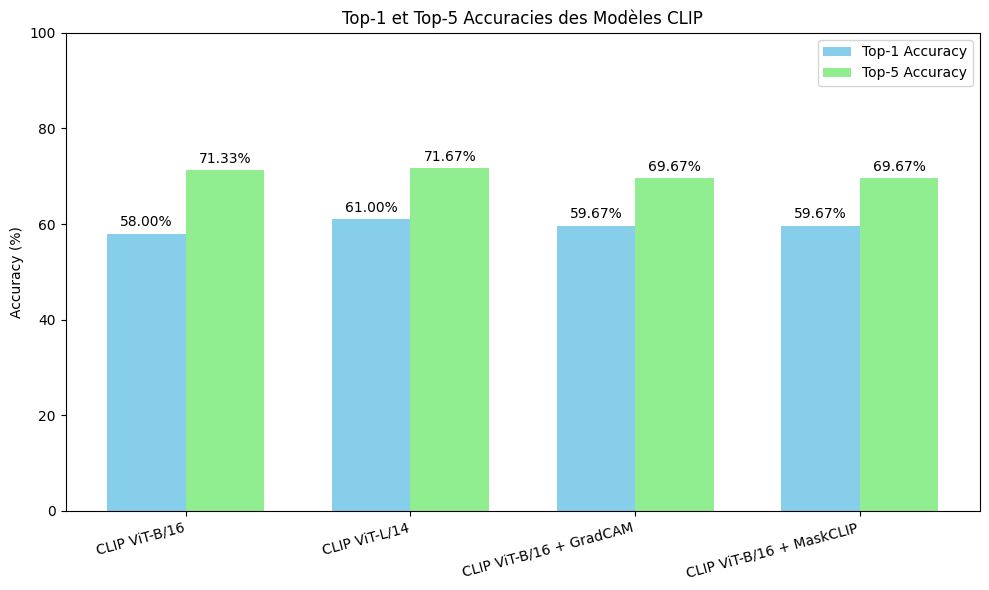

In [63]:
import matplotlib.pyplot as plt
import numpy as np

res_clip_b16          = results_clip_vit_base_patch16                 # CLIP ViT-B/16
res_clip_l14          = results_clip_vit_base_patch14                 # CLIP ViT-L/14
res_clip_b16_gradcam  = results_clip_vit_base_patch16_with_gradcam    # CLIP ViT-B/16 + GradCAM
res_clip_b16_maskclip = results_clip_vit_base_patch16_with_maskclip   # CLIP ViT-B/16 + MaskCLIP

model_names = [
    "CLIP ViT-B/16",
    "CLIP ViT-L/14",
    "CLIP ViT-B/16 + GradCAM",
    "CLIP ViT-B/16 + MaskCLIP"
]

top1_accuracies = [
    res_clip_b16["top1"],
    res_clip_l14["top1"],
    res_clip_b16_gradcam["top1"],
    res_clip_b16_maskclip["top1"]
]

top5_accuracies = [
    res_clip_b16["top5"],
    res_clip_l14["top5"],
    res_clip_b16_gradcam["top5"],
    res_clip_b16_maskclip["top5"]
]

# Plot
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, top1_accuracies, width, label='Top-1 Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, top5_accuracies, width, label='Top-5 Accuracy', color='lightgreen')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Top-1 et Top-5 Accuracies des Modèles CLIP')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.set_ylim(0, 100)
ax.legend()

# Valeurs sur les barres
for bar in bars1 + bars2:
    h = bar.get_height()
    ax.annotate(f'{h:.2f}%',
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


Nous constatons que le modèle VIT-B/16 est performant en combinant la loss globale et la loss locale. En effet, la loss arrive à converger dès les premières itérations. C'est moins le cas pour VIT-L/14 qui oscille. Avec un temps d'exécution raisonnable, nous avons tenté de varier les hyperparamètres. Nous n'avons pas forcément eu d'effet notable sur l'entraînement. Nous pourrons affirmer que les résultats sont satisfaisants et sont alignés avec ceux« attendus dans le papier.

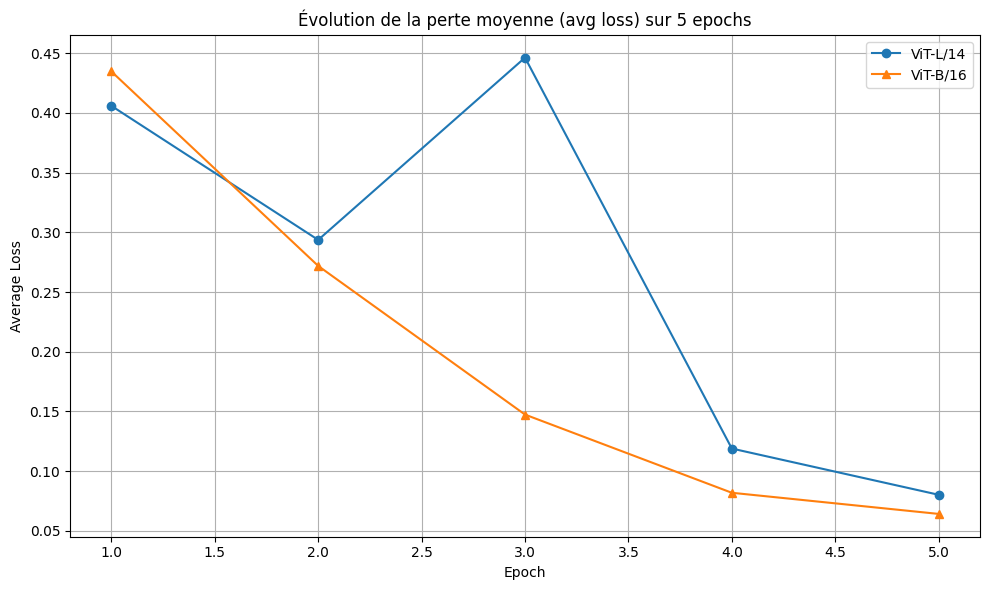

In [59]:
epochs = list(range(1, 6))  # 5 epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_losses_clip_vit_large_patch14, marker='o', label='ViT-L/14')
plt.plot(epochs, avg_losses_clip_vit_base_patch16, marker='^', label='ViT-B/16')

plt.title("Évolution de la perte moyenne (avg loss) sur 5 epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

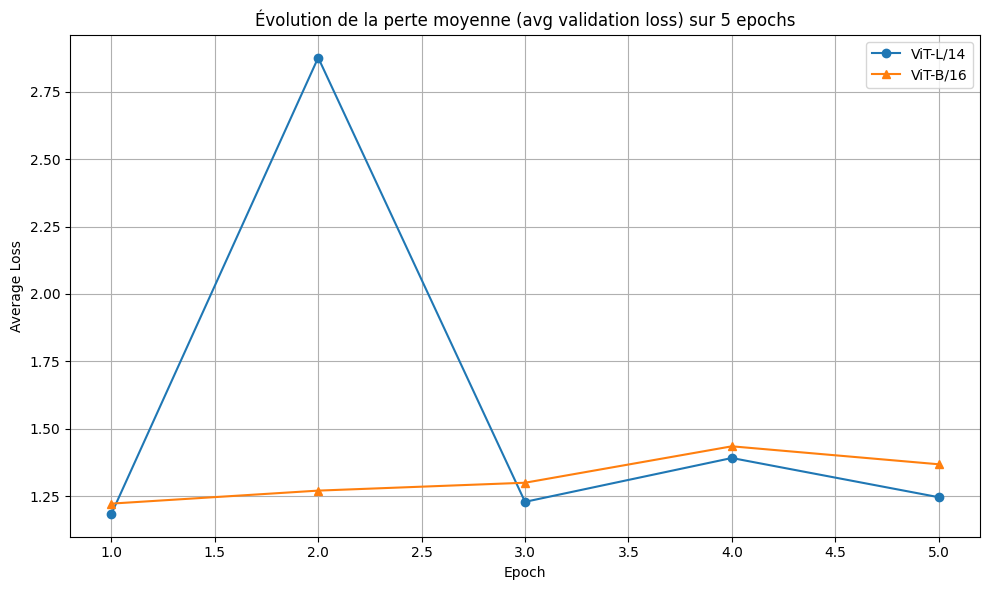

In [62]:
epochs = list(range(1, 6))  # 5 epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_val_losses_clip_vit_large_patch14, marker='o', label='ViT-L/14')
plt.plot(epochs, avg_val_losses_clip_vit_base_patch16, marker='^', label='ViT-B/16')

plt.title("Évolution de la perte moyenne (avg validation loss) sur 5 epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Analyse de l'évolution de la fonction de perte

La courbe montrant l'évolution de l'average loss en fonction des itérations est très instructif. Pour un petit nombre d'itérations, nous constatons que les modèles VIT-L/14 et VIT-B/16 convergent. (à compléter par Nohalia avec la loss validation)

## Analyse de la phase d'évaluation
Le fine-tuning a un effet légèrement positif sur les performances en termes de Top-1 et Top-5 accuracy. En général, on observe une amélioration de ces métriques après le fine-tuning. Cela veut dire que le modèle s’adapte mieux aux données spécifiques de la tâche et reconnaît plus précisément les classes correctes. Ainsi, le modèle VIT-B/16 est meilleur que VIT-L/14 en raison de sa rapidité d'exécution et de sa capacité à travailler sur des images assez variées.



## Conclusion

Ce projet a été très enrichissant. En effet, nous avons mis en pratique les connaissances acquises en computer vision et sur l'interprétabilité des modèles mêlant la vision et le langage.
En rencontrant quelques difficultés lors du fine-tuning de CLIP, nous avons su les surmonter en alignant notre approche avec les attentes figurant dans le papier. Un des obstacles est d'avoir su gérer la taille du dataset d'entraînement montrant les images. Par ailleurs, le choix d'un nombre d'images à mettre dans notre dataset de validation et le nombre d'itérations durant la phase d'entraînement étaient primordiaux afin d'avoir une rapidité d'exécution du modèle.

Nous avons donc réussi à atteindre des performances intéressantes.
Certains modèles détectent la classe correcte dans les premières positions. Cela est en accord avec les résultats détaillés dans notre papier.
Bien que la métrique Average Precision (AE) soit adaptée pour des évaluations régionales plus fines, nous ne l'avons pas implémentée dans ce projet en raison de contraintes de temps et de complexité technique. De plus, notre évaluation s’est concentrée sur des prédictions globales d’image, pour lesquelles les métriques Top-1 et Top-5 se sont révélées suffisantes pour mesurer l’impact du fine-tuning.

A l'avenir, nous souhaiterions nous focaliser sur les pistes suivantes: 

- **L'amélioration des stratégies de prétraitement des images** pour mieux exploiter les données fournies.
- **L'évaluation des modèles** sur des métriques plus complexes (Average Precision) pour la classification multi-labels

En conclusion, ce projet nous a permis d’appliquer nos connaissances à un problème réel. Ce projet constitue une expérience stimulante qui sera très gratifiante lors de futures études sur l'interprétabilité des modèles de transformers.
